# Proteogenomic Integration of Diffuse Large B-cell Lymphomas (DLBCL)
This notebook demonstrates how to apply `MuVI` on the DLBCL discovery cohort, in order to infer a joint latent space that is guided by the informative prior knowledge of transcriptomic signatures that reflect biological differences among malignant lymphomas.

#### Uncomment the following lines to install MuVI

In [1]:
# %pip install muvi==0.1.5
# %pip install anndata==0.10.8

In [2]:
import numpy as np
import pandas as pd
import mudata as mu

In [3]:
import muvi

/home/aqoku/miniconda3/envs/muvi_dlbcl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%matplotlib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f85bb63c6f0>


In [5]:
# plotting settings
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

Run a quick check if GPU(s) are available and select the least utilized GPU to perform the optimization.

In [6]:
device = "cpu"
try:
    device = f"cuda:{muvi.get_free_gpu_idx()}"
except Exception as e:
    print(e)
device

'cuda:3'

Load the MuData object from the `.h5mu` file:

In [7]:
mdata = mu.read("dlbcl_processed.h5mu")
mdata

MuData object with n_obs × n_vars = 332 × 12000
  obs:	'cell_of_origin', 'Lymphgen_Class_MYC', 'doub_trib_hit', 'OS_Followup_Y', 'OS_status', 'MHG', 'cluster_AIC', 'ICDO3', 'stromal_quantile_rank', 'prolif_quantile_rank', 'ecotype', 'rchop_real', 'IPI', 'cell_state', 'stromal_1', 'prolif'
  var:	'symbols'
  2 modalities
    1_rna:	332 x 6000
      var:	'symbols'
      varm:	'gene_set_mask'
    2_prot:	332 x 6000
      var:	'symbols'
      varm:	'gene_set_mask'

Create a `MuVI` model directly from the `MuData` object by providing the necessary arguments such as the `varm` key for the numerically encoded prior information of the gene set annotations.

In [8]:
model = muvi.tl.from_mdata(
    mdata,
    prior_mask_key="gene_set_mask",
    view_names=["1_rna", "2_prot"],
    n_factors=2,
    device=device,
)
model

2024-11-22 17:25:19,027 - muvi.core.models - INFO - pd.DataFrame detected.
2024-11-22 17:25:19,028 - muvi.core.models - INFO - Storing the index of the view `1_rna` as sample names.
2024-11-22 17:25:19,029 - muvi.core.models - INFO - pd.DataFrame detected.
2024-11-22 17:25:19,030 - muvi.core.models - INFO - pd.DataFrame detected.
2024-11-22 17:25:19,031 - muvi.core.models - INFO - pd.DataFrame detected.
2024-11-22 17:25:20,040 - muvi.core.models - INFO - pd.DataFrame detected.
2024-11-22 17:25:20,069 - muvi.core.models - INFO - Storing the index of the mask `1_rna` as factor names.
2024-11-22 17:25:20,074 - muvi.core.models - INFO - pd.DataFrame detected.
2024-11-22 17:25:20,402 - muvi.core.models - INFO - Likelihoods set to `{'1_rna': 'normal', '2_prot': 'normal'}`.
2024-11-22 17:25:20,403 - muvi.core.models - INFO - NMF set to `{'1_rna': False, '2_prot': False}`.
2024-11-22 17:25:20,404 - muvi.core.models - INFO - Normalizing observations.
2024-11-22 17:25:20,405 - muvi.core.models -

|==================================================|
|                MuVI version 0.1.5                |
|==================================================|
| Parameter        | Value                         |
|------------------|-------------------------------|
| n_views          | 2                             |
| n_samples        | 332                           |
| n_features       | 1_rna: 6000, 2_prot: 6000     |
| n_factors        | 293                           |
| prior_confidence | 0.99                          |
| n_covariates     | 0                             |
| likelihoods      | 1_rna: normal, 2_prot: normal |
| nmf              | 1_rna: False, 2_prot: False   |
| reg_hs           | True                          |
| device           | cuda:3                        |
|==================================================|

In [9]:
model.fit(seed=0)

2024-11-22 17:25:20,491 - muvi.core.models - INFO - Using 3 particles in parallel.
2024-11-22 17:25:20,492 - muvi.core.models - INFO - Preparing model and guide...
2024-11-22 17:25:20,627 - muvi.core.models - INFO - Preparing optimizer...
2024-11-22 17:25:20,628 - muvi.core.models - INFO - Decaying learning rate over 10000 iterations.
2024-11-22 17:25:20,629 - muvi.core.models - INFO - Preparing SVI...
2024-11-22 17:25:20,631 - muvi.core.models - INFO - Preparing training data...
2024-11-22 17:25:20,646 - muvi.core.models - INFO - Using complete dataset.
2024-11-22 17:25:20,652 - muvi.core.models - INFO - Setting training seed to `0`.
2024-11-22 17:25:20,659 - muvi.core.models - INFO - Cleaning parameter store.
2024-11-22 17:25:20,660 - muvi.core.models - INFO - Starting training...


  0%|          | 0/10000 [00:00<?, ?it/s]

2024-11-22 17:25:22,163 - root - INFO - Guessed max_plate_nesting = 3


 43%|████▎     | 4334/10000 [08:15<10:48,  8.74it/s, ELBO=1.69e+4]

Relative improvement of -0.000176 < 1e-05 for 10 step(s) in a row, stopping early.
2024-11-22 17:33:36,464 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


## Downstream Analysis

Once the training terminates, we may call `muvi.tl.foo` followed by `muvi.pl.foo` to apply different analysis tools and plot the results, similar to the usage principles of `scanpy`.

Under the hood, `muvi` stores every intermediate result in a `model._cache.factor_adata` such as variance explained by each factor, significance of each factor with respect to the prior information and so on.

In [10]:
_ = muvi.tl.variance_explained(model)

2024-11-22 17:33:36,625 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


/home/aqoku/miniconda3/envs/muvi_dlbcl/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Next, we perform a statistical test ([PCGSE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4543476/)) to determine how well the inferred factors match the prior information representing each pathway. Here, we apply a correlation adjusted one-sided t-test, and correcting for multiple testing.

In [11]:
_ = muvi.tl.test(model)

2024-11-22 17:33:52,035 - muvi.tools.utils - WARNING - No feature sets provided for `1_rna`, extracting feature sets from the prior mask.


100%|██████████| 264/264 [00:15<00:00, 16.70it/s]

2024-11-22 17:34:08,250 - muvi.tools.utils - WARNING - No feature sets provided for `2_prot`, extracting feature sets from the prior mask.



100%|██████████| 275/275 [00:16<00:00, 16.49it/s]


2024-11-22 17:34:25,321 - muvi.tools.utils - WARNING - No feature sets provided for `1_rna`, extracting feature sets from the prior mask.


100%|██████████| 264/264 [00:15<00:00, 16.92it/s]

2024-11-22 17:34:41,336 - muvi.tools.utils - WARNING - No feature sets provided for `2_prot`, extracting feature sets from the prior mask.



100%|██████████| 275/275 [00:16<00:00, 16.28it/s]


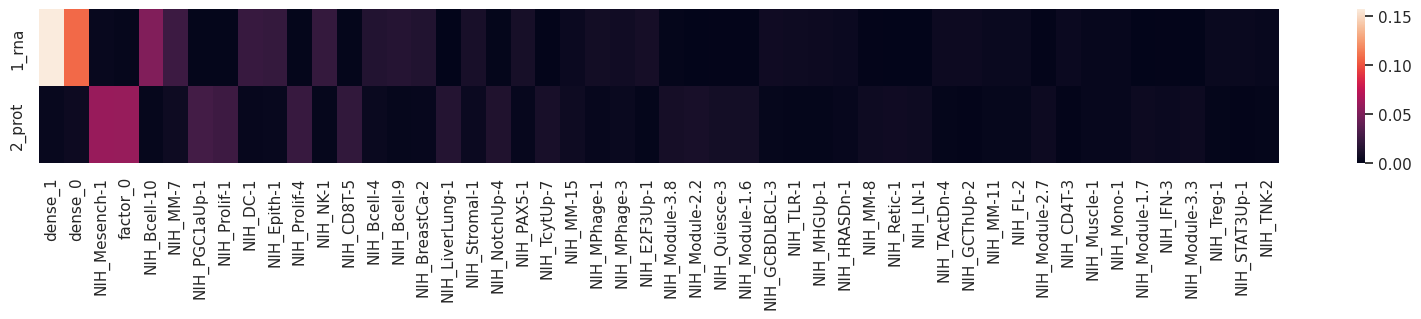

<Axes: >

In [12]:
muvi.pl.variance_explained(model)

Now we may plot an overview of the most relevant factors by combining the variance explained and the results of the statistical test. Since we applied a one-sided hypothesis test, each significant factor is marked by a `(+)` or `(-)` indicating the significance direction. A factor may also be significant in both directions. However, we report the more significant direction based on the lower p-value.

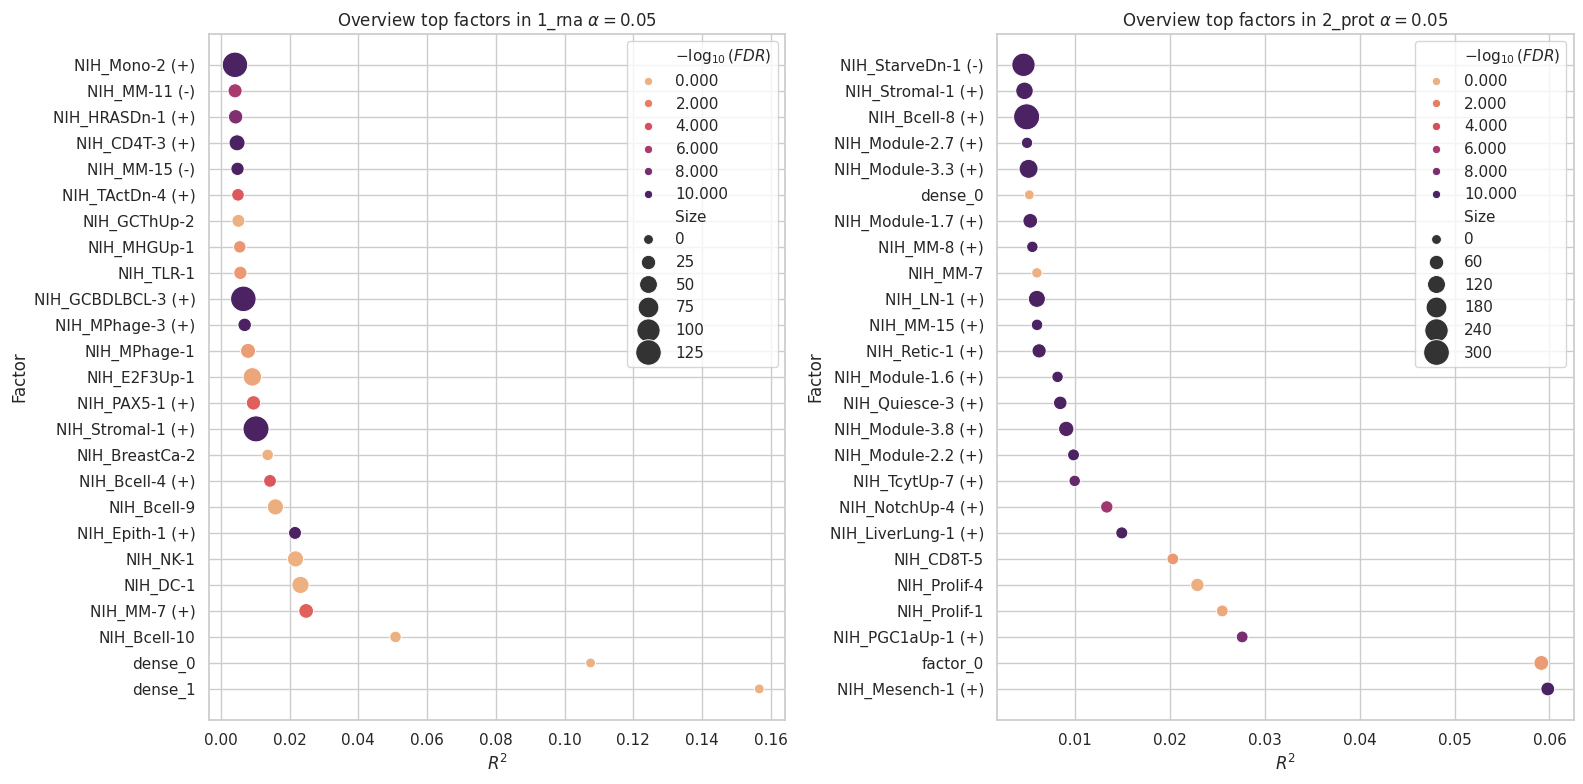

(<Figure size 1600x800 with 2 Axes>,
 array([[<Axes: title={'center': 'Overview top factors in 1_rna $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>,
         <Axes: title={'center': 'Overview top factors in 2_prot $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>]],
       dtype=object))

In [13]:
muvi.pl.factors_overview(model)

In [14]:
# add obs metadata
model._cache.factor_adata.obs = mdata.obs.copy()

After copying the metadata stored in `mdata.obs`, we may perform a typical `scanpy` analysis such as computing a neighborhood graph in the latent space, applying a clustering algorithm on the pathway level, and embedding the neighborhood graph in two dimensions for visualization purposes. 

Optionally, we may filter only the relevant factors before performing the steps mentioned above. This is useful to reduce the number of factors involved in the analysis by removing factors that explain little to no variance in the data.

In [15]:
muvi.tl.filter_factors(model, r2_thresh=0.9)

2024-11-22 17:35:01,357 - muvi.tools.utils - INFO - Filtering down to 132 factors.
2024-11-22 17:35:01,360 - muvi.tools.cache - INFO - Factors filtered successfully.


True

In [16]:
muvi.tl.neighbors(model)
muvi.tl.leiden(model, resolution=0.9)
muvi.tl.umap(model)

/home/aqoku/miniconda3/envs/muvi_dlbcl/lib/python3.9/site-packages/muvi/tools/utils.py:770: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  return cluster_fn(setup_cache(model).factor_adata, **kwargs)


In [17]:
mdata.obs.keys()

Index(['cell_of_origin', 'Lymphgen_Class_MYC', 'doub_trib_hit',
       'OS_Followup_Y', 'OS_status', 'MHG', 'cluster_AIC', 'ICDO3',
       'stromal_quantile_rank', 'prolif_quantile_rank', 'ecotype',
       'rchop_real', 'IPI', 'cell_state', 'stromal_1', 'prolif'],
      dtype='object')

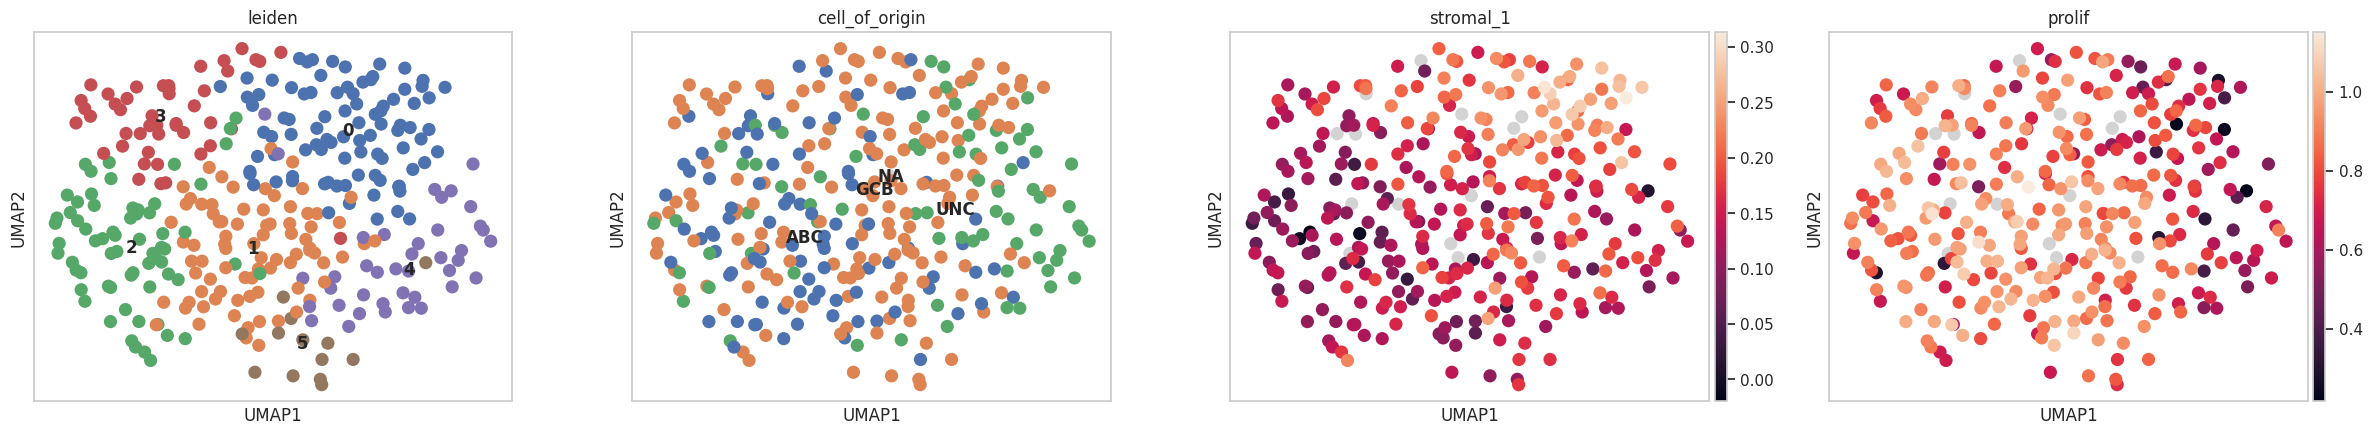

In [18]:
groupby = "leiden"
color = [groupby, "cell_of_origin", "stromal_1", "prolif"]
muvi.pl.umap(model, color, legend_loc="on data")

The inferred latent space captures major axes of variation such as different cell types. Next, we look into specific factors (pathways) that explain variance within specific cell types. 

In [19]:
muvi.tl.rank(model, "cell_of_origin", method="wilcoxon")

/home/aqoku/miniconda3/envs/muvi_dlbcl/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/aqoku/miniconda3/envs/muvi_dlbcl/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/aqoku/miniconda3/envs/muvi_dlbcl/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


2024-11-22 17:35:11,424 - muvi.tools.plotting - WARNING - dendrogram data not found (using `dendrogram_cell_of_origin` as key). Running `muvi.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `muvi.tl.dendrogram` independently.


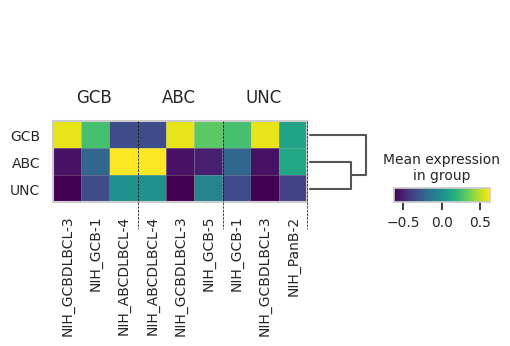

<Axes: >

In [20]:
muvi.pl.rank(model, n_factors=3, pl_type="matrixplot")

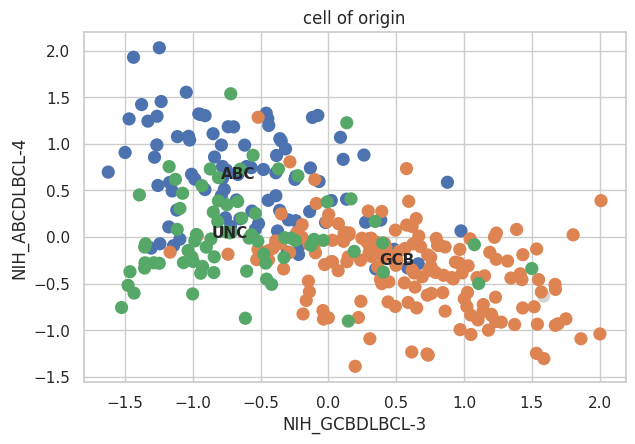

In [21]:
muvi.pl.scatter(
    model,
    "NIH_GCBDLBCL-3",
    "NIH_ABCDLBCL-4",
    "cell_of_origin",
    legend_loc="on data",
)

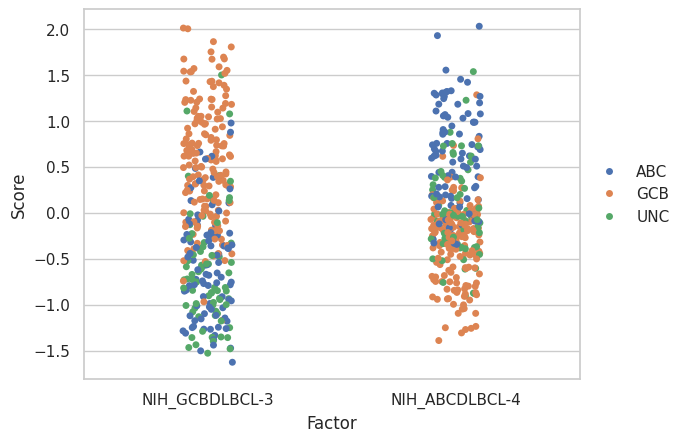

<Axes: xlabel='Factor', ylabel='Score'>

In [22]:
muvi.pl.stripplot(model, ["NIH_GCBDLBCL-3","NIH_ABCDLBCL-4"], "cell_of_origin", rot=0)

To inspect a single factor in a single view regarding its factors loadings, simply call `muvi.pl.inspect_factor`. The features originating from the prior gene set annotation are shown as annotated (black), whereas the new features added during training are shown as inferred (red). As a result, we obtain a data-driven refinement of the prior feature sets.

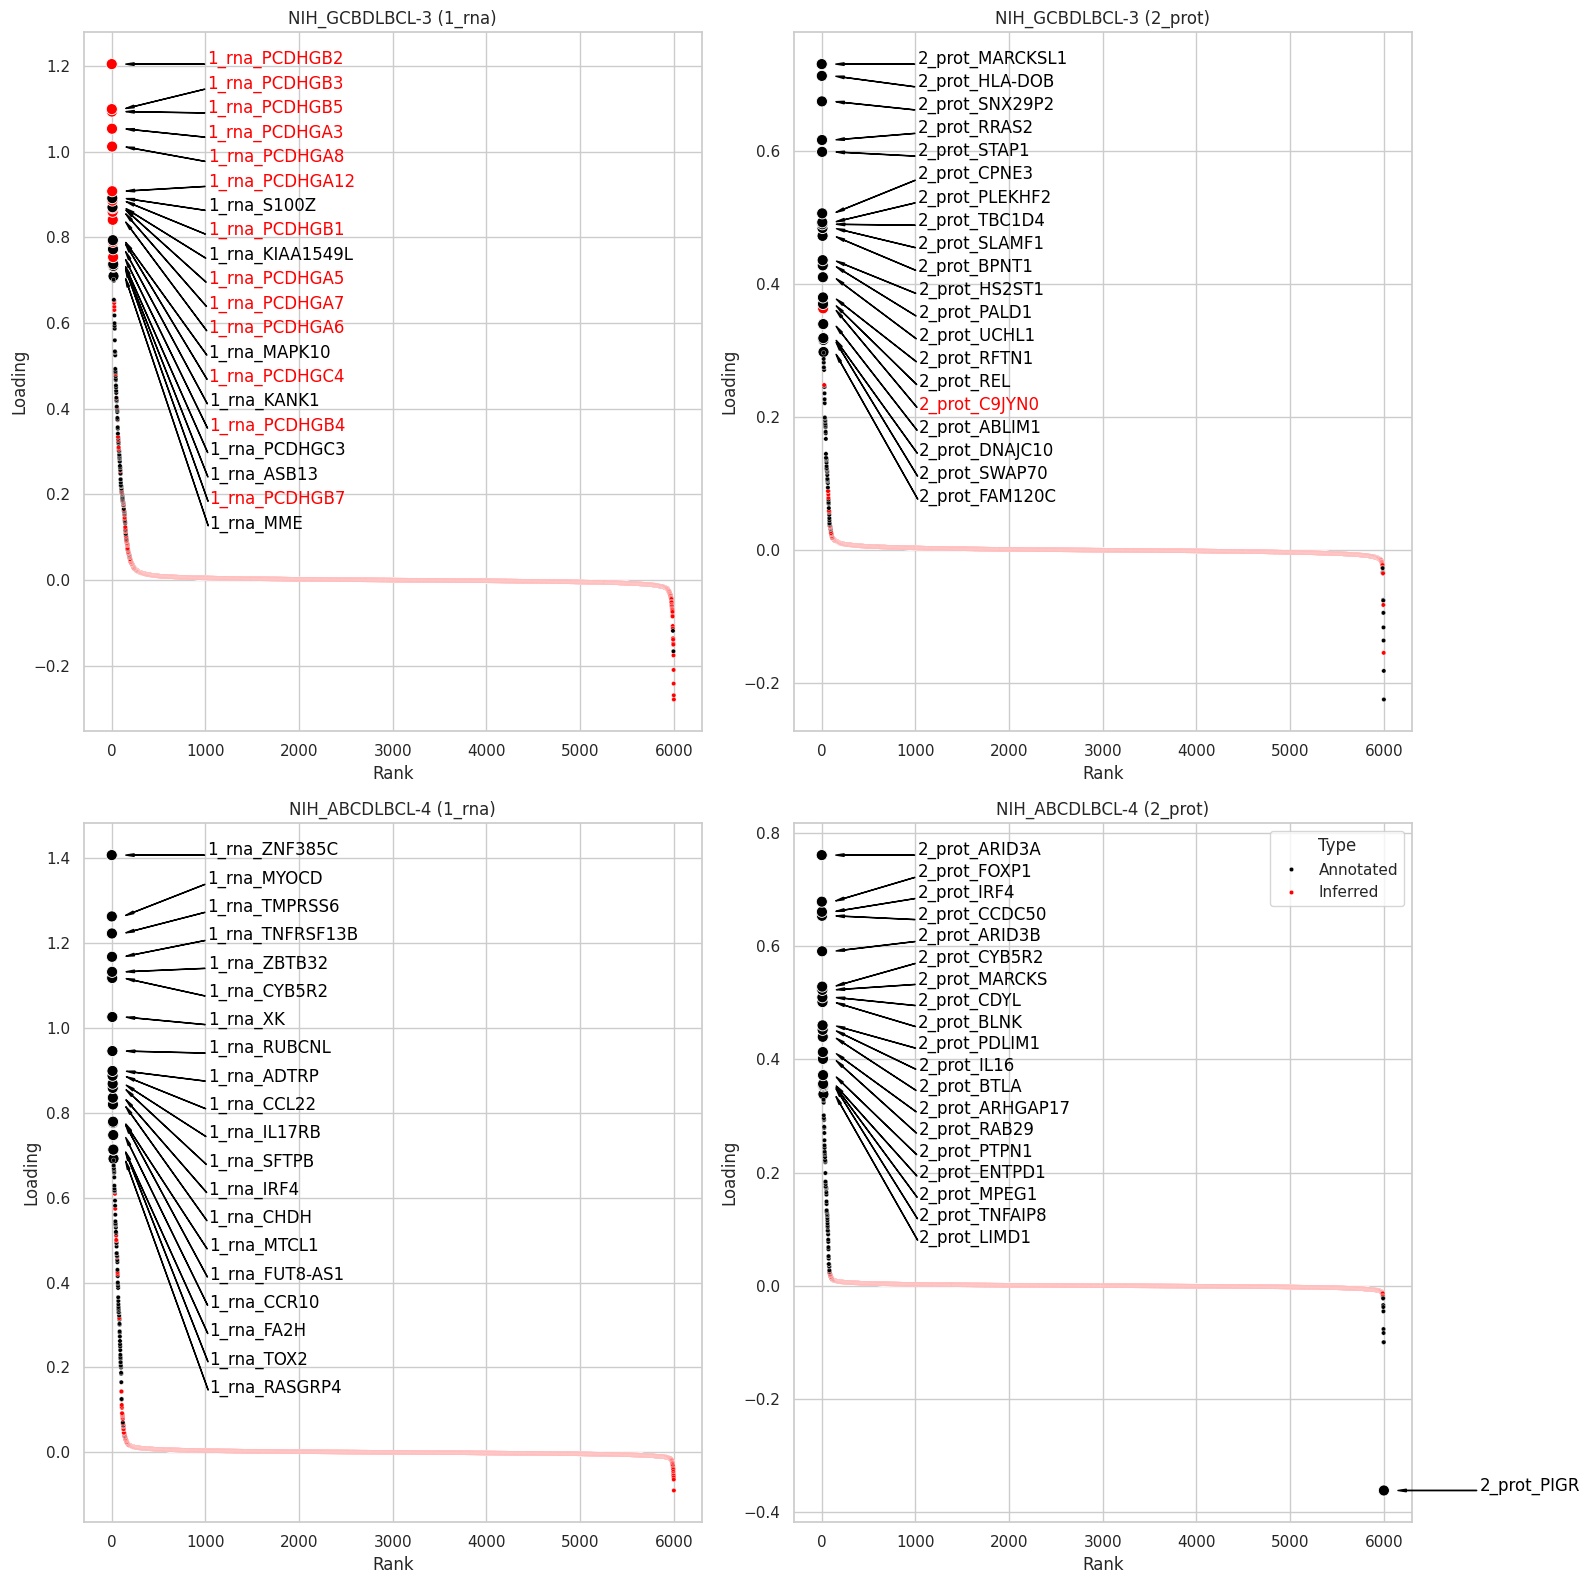

(<Figure size 1600x1600 with 4 Axes>,
 array([[<Axes: title={'center': 'NIH_GCBDLBCL-3 (1_rna)'}, xlabel='Rank', ylabel='Loading'>,
         <Axes: title={'center': 'NIH_GCBDLBCL-3 (2_prot)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'NIH_ABCDLBCL-4 (1_rna)'}, xlabel='Rank', ylabel='Loading'>,
         <Axes: title={'center': 'NIH_ABCDLBCL-4 (2_prot)'}, xlabel='Rank', ylabel='Loading'>]],
       dtype=object))

In [25]:
muvi.pl.inspect_factor(
    model,
    ["NIH_GCBDLBCL-3","NIH_ABCDLBCL-4"],
    top=20,
)

Finally, we may `save` the model on disk and `load` it later to resume the analysis.

In [26]:
# muvi.save(model, "some_model_output_directory")
# model = muvi.load("some_model_output_directory")